In [7]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

print("ANÁLISIS DE MÉTRICAS AVANZADAS")
print(f"Ejecutado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# CARGAR DATOS LIMPIOS GUARDADOS
print("Cargando datos limpios preprocesados...")
df_clean = pd.read_csv('../data/online_retail_clean.csv')

print(f"Datos cargados: {len(df_clean):,} filas")
print("Columnas disponibles:", list(df_clean.columns))

# CONFIGURAR DUCKDB
con = duckdb.connect()
con.register('ventas', df_clean)
print("DuckDB configurado")

# Verificación rápida
result = con.execute("SELECT COUNT(*) as total FROM ventas").fetchdf()
print(f"Verificación: {result['total'].iloc[0]:,} filas en tabla 'ventas'")


ANÁLISIS DE MÉTRICAS AVANZADAS
Ejecutado: 2025-10-27 15:48:21
Cargando datos limpios preprocesados...
Datos cargados: 805,549 filas
Columnas disponibles: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'Total_Revenue']
DuckDB configurado
Verificación: 805,549 filas en tabla 'ventas'


In [9]:
# Análisis de Revenue Mensual
print("ANÁLISIS DE REVENUE MENSUAL")
print("=" * 40)

# Cargar y ejecutar query 
with open('../sql_queries/01_monthly_revenue.sql', 'r') as file:
    revenue_query = file.read()

monthly_revenue_df = con.execute(revenue_query).fetchdf()
print(f"Resultados: {len(monthly_revenue_df):,} filas")
display(monthly_revenue_df.head(10))

# Resumen por estado del cliente
print("\n RESUMEN POR ESTADO DE CLIENTE:")
resumen_estado = con.execute("""
    SELECT 
        estado_cliente,
        COUNT(*) as total_clientes,
        SUM(ingreso_mensual) as revenue_total,
        AVG(ingreso_mensual) as revenue_promedio
    FROM monthly_revenue_df
    GROUP BY estado_cliente
    ORDER BY revenue_total DESC
""").fetchdf()
display(resumen_estado)

ANÁLISIS DE REVENUE MENSUAL
Resultados: 25,595 filas


,mes,customer_id,ingreso_mensual,estado_cliente,cambio_revenue
0,2009-12-01,12346,113.50,Nuevo,113.50
1,2010-01-01,12346,90.00,Contraccion,-23.50
2,2010-03-01,12346,27.05,Contraccion,-62.95
3,2010-06-01,12346,142.31,Expansion,115.26
4,2011-01-01,12346,77183.60,Expansion,77041.29
5,2010-10-01,12347,611.53,Nuevo,611.53
6,2010-12-01,12347,1423.58,Expansion,812.05
7,2011-01-01,12347,475.39,Contraccion,-948.19
8,2011-04-01,12347,636.25,Expansion,160.86
9,2011-06-01,12347,382.52,Contraccion,-253.73



 RESUMEN POR ESTADO DE CLIENTE:


,estado_cliente,total_clientes,revenue_total,revenue_promedio
0,Expansion,9697,9617321.194,991.783149
1,Contraccion,9971,5057875.846,507.258635
2,Nuevo,5878,3049899.428,518.866864
3,Mantenimiento,49,18332.710,374.136939


### Resumen de Growth Accounting

Los resultados muestran la contribución al ingreso (Revenue) total por el estado financiero de los clientes. Esta descomposición es vital para entender las palancas de crecimiento.

| Estado | Total Mes-Cliente | Ingreso Total (`revenue_total`) | Ingreso Promedio (`revenue_promedio`) | Interpretación de Negocio |
| :--- | :--- | :--- | :--- | :--- |
| **Expansión** | 9,697 | $9,617,321 | $991.78 | Clientes que aumentaron su gasto respecto al mes anterior. **El principal motor de crecimiento.** |
| **Contracción** | 5,057 | $5,057,875 | $507.25 | Clientes que disminuyeron su gasto respecto al mes anterior. **Representa la fuga de valor.** |
| **Nuevo** | 5,878 | $3,049,899 | $518.87 | Clientes que hicieron su primera compra en el mes. **Ingreso por adquisición.** |
| **Mantenimiento** | 49 | $18,332 | $374.14 | Clientes que gastaron exactamente lo mismo que el mes anterior. |

**Hallazgo Clave:**
* El **Ingreso por Expansión ($9.6M)** es el mayor contribuyente, lo que indica una buena salud de retención y éxito en el *upselling* de clientes existentes.
* El **Ingreso Neto (Expansión - Contracción)** es positivo y significativo, señalando un crecimiento robusto.

In [12]:
#  Análisis de Cohortes
print("ANÁLISIS DE COHORTES - RETENCIÓN")
print("=" * 45)

# Cargar y ejecutar query 
with open('../sql_queries/02_cohort_analysis.sql', 'r') as file:
    cohort_query = file.read()

cohort_df = con.execute(cohort_query).fetchdf()
print(f"Matriz de cohortes generada: {len(cohort_df):,} filas")

# Crear matriz pivote para visualización
cohort_pivot = cohort_df.pivot_table(
    index='cohort_mes',
    columns='mes_numero',
    values='retencion_porcentaje',
    aggfunc='first'
)

print("MATRIZ DE RETENCIÓN POR COHORTE:")
display(cohort_pivot)

ANÁLISIS DE COHORTES - RETENCIÓN
Matriz de cohortes generada: 325 filas
MATRIZ DE RETENCIÓN POR COHORTE:


mes_numero,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
cohort_mes,,,,,,,,,,,,,,,,,,,,,
2009-12-01,100.0,35.29,33.40,42.51,38.01,35.92,37.70,34.24,33.61,36.23,...,30.26,26.28,30.26,28.27,25.97,25.55,31.52,30.47,40.73,19.69
2010-01-01,100.0,20.63,31.07,30.55,26.37,30.03,25.85,22.98,27.94,31.85,...,15.14,23.50,19.84,18.54,19.58,24.28,19.32,24.54,5.74,NaN
2010-02-01,100.0,23.80,22.46,29.14,24.60,20.05,19.25,28.61,25.40,27.54,...,20.05,16.04,16.31,14.44,22.99,22.99,16.31,5.88,NaN,NaN
2010-03-01,100.0,18.96,23.02,24.15,23.25,20.32,24.60,30.25,27.54,10.84,...,16.93,17.38,15.58,17.61,20.09,21.22,7.90,NaN,NaN,NaN
2010-04-01,100.0,19.39,19.39,16.33,18.37,22.45,27.55,26.19,10.54,10.88,...,15.65,13.95,14.97,18.03,22.45,5.78,NaN,NaN,NaN,NaN
2010-05-01,100.0,15.75,16.93,17.32,17.72,25.59,21.26,12.60,5.91,8.27,...,12.60,13.78,16.54,15.35,4.72,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,17.41,18.89,20.37,22.96,28.52,12.59,8.89,8.15,11.85,...,12.22,13.33,20.37,5.19,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,15.59,18.28,29.57,29.03,13.98,11.29,14.52,14.52,11.29,...,17.20,23.66,8.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,20.37,29.63,32.10,17.28,11.73,9.88,12.35,13.58,12.96,...,19.75,6.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Retención de Clientes: Análisis de Cohortes 

Este análisis mide la lealtad del cliente calculando el porcentaje de la cohorte inicial (clientes adquiridos en un mes específico) que regresó a comprar en los meses subsiguientes.

### Hallazgos Clave de la Retención:

* **Caída Inicial:** La retención cae drásticamente después del mes de adquisición (Mes 0), con la mayoría de las cohortes perdiendo entre el 60% y el 80% de sus clientes en el Mes 1.
* **Retención a Largo Plazo:** A partir del Mes 6, la retención tiende a estabilizarse. Las cohortes iniciales (2009-12-01) mantienen consistentemente una retención superior al 20% incluso después de un año.
* **Calidad de Cohortes:** La cohorte de **2010-12-01** muestra una retención inicial del **9.21%** en el Mes 1, lo cual es inferior al promedio (cercano al 30%), lo que sugiere un problema en la calidad de la adquisición o la oferta durante ese período.

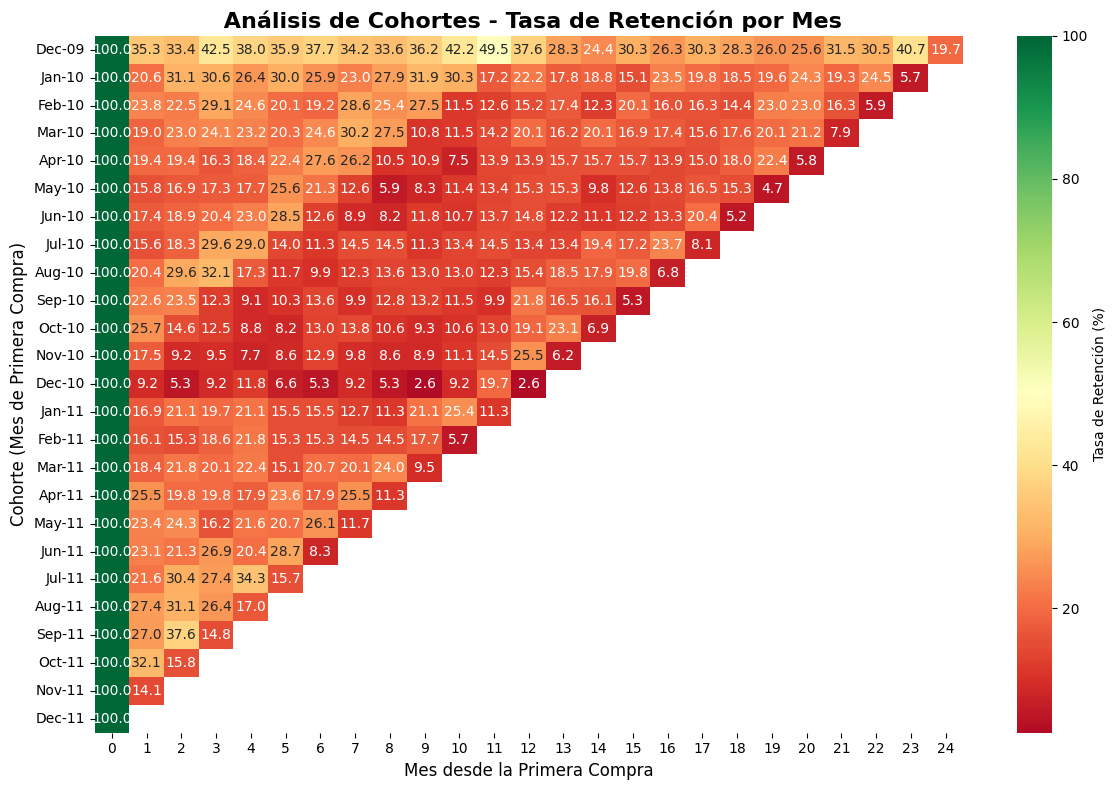

Heatmap guardado en: assets/cohort_retention_heatmap.png


In [18]:
#  Heatmap de Retención
plt.figure(figsize=(12, 8))
sns.heatmap(
    cohort_pivot, 
    annot=True, 
    fmt='.1f', 
    cmap='RdYlGn',
    center=50,
    cbar_kws={'label': 'Tasa de Retención (%)'}
)
plt.title(' Análisis de Cohortes - Tasa de Retención por Mes', fontsize=16, fontweight='bold')
plt.xlabel('Mes desde la Primera Compra', fontsize=12)
plt.ylabel('Cohorte (Mes de Primera Compra)', fontsize=12)
plt.tight_layout()
plt.savefig('../assets/cohort_retention_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmap guardado en: assets/cohort_retention_heatmap.png")

EVOLUCIÓN DE REVENUE POR ESTADO DE CLIENTE


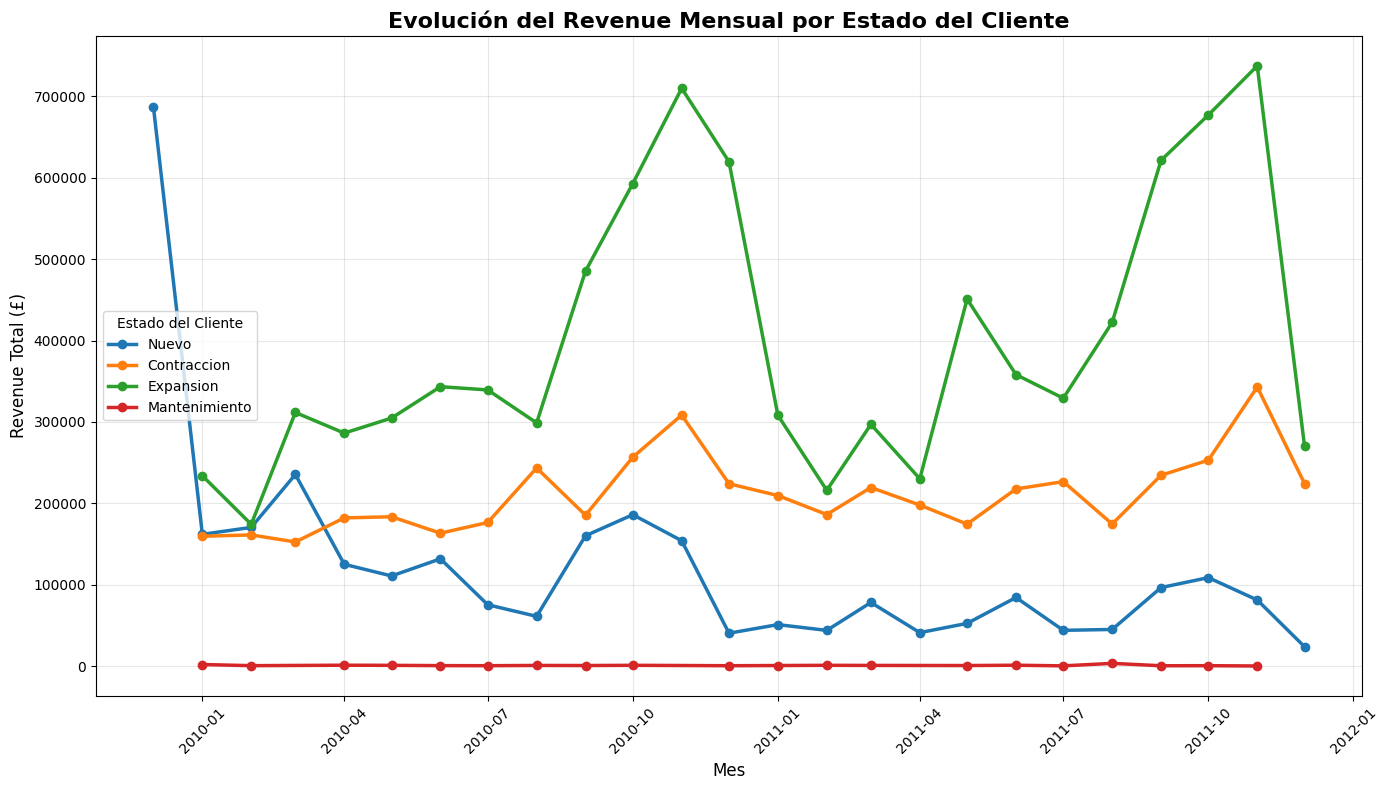

In [16]:
# Evolución Temporal de Revenue
print("EVOLUCIÓN DE REVENUE POR ESTADO DE CLIENTE")
print("=" * 55)

# Preparar datos para visualización
evolution_data = con.execute("""
    SELECT 
        mes,
        estado_cliente,
        SUM(ingreso_mensual) as total_revenue,
        COUNT(DISTINCT customer_id) as total_clientes
    FROM monthly_revenue_df
    GROUP BY mes, estado_cliente
    ORDER BY mes, estado_cliente
""").fetchdf()

# Gráfico de evolución
plt.figure(figsize=(14, 8))
for estado in evolution_data['estado_cliente'].unique():
    subset = evolution_data[evolution_data['estado_cliente'] == estado]
    plt.plot(subset['mes'], subset['total_revenue'], marker='o', linewidth=2.5, label=estado)

plt.title('Evolución del Revenue Mensual por Estado del Cliente', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Revenue Total (£)', fontsize=12)
plt.legend(title='Estado del Cliente')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../assets/revenue_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Cálculo de LTV y CAC
print("CÁLCULO DE LIFETIME VALUE (LTV)")
print("=" * 45)

# Ejecutar query
with open('../sql_queries/03_ltv_cac.sql', 'r') as file:
    ltv_query = file.read()

ltv_df = con.execute(ltv_query).fetchdf()
print(f"LTV calculado para {len(ltv_df):,} clientes")

# Métricas resumen de LTV
ltv_summary = con.execute("""
    SELECT 
        COUNT(*) as total_clientes,
        ROUND(AVG(lifetime_value), 2) as ltv_promedio,
        ROUND(MAX(lifetime_value), 2) as ltv_maximo,
        ROUND(MIN(lifetime_value), 2) as ltv_minimo,
        ROUND(AVG(meses_activo), 1) as meses_activo_promedio,
        ROUND(SUM(lifetime_value), 2) as ltv_total
    FROM ltv_df
""").fetchdf()

print("RESUMEN DE LTV:")
display(ltv_summary)

# Simulación de CAC (Customer Acquisition Cost)
print("\n SIMULACIÓN DE CAC (Customer Acquisition Cost)")
cac_simulado = 50  # £ por cliente - valor típico para e-commerce
ltv_promedio = ltv_summary['ltv_promedio'].iloc[0]
ratio_ltv_cac = ltv_promedio / cac_simulado

print(f"   - CAC Simulado: £{cac_simulado}")
print(f"   - LTV Promedio: £{ltv_promedio:.2f}")
print(f"   - Ratio LTV/CAC: {ratio_ltv_cac:.2f}")

if ratio_ltv_cac > 3:
    print("   EXCELENTE: Ratio LTV/CAC > 3 (negocio saludable)")
elif ratio_ltv_cac > 1:
    print("   ACEPTABLE: Ratio LTV/CAC > 1 (negocio viable)")
else:
    print("   PROBLEMÁTICO: Ratio LTV/CAC ≤ 1 (pérdidas por cliente)")

CÁLCULO DE LIFETIME VALUE (LTV)
LTV calculado para 5,878 clientes
RESUMEN DE LTV:


,total_clientes,ltv_promedio,ltv_maximo,ltv_minimo,meses_activo_promedio,ltv_total
0,5878,3018.62,608821.65,2.95,4.4,17743429.18



 SIMULACIÓN DE CAC (Customer Acquisition Cost)
   - CAC Simulado: £50
   - LTV Promedio: £3018.62
   - Ratio LTV/CAC: 60.37
   EXCELENTE: Ratio LTV/CAC > 3 (negocio saludable)


## Rentabilidad: Lifetime Value (LTV) y Ratio LTV/CAC 

El LTV es el ingreso total que una empresa puede esperar razonablemente de una cuenta de cliente promedio a lo largo de su relación. Compararlo con el Costo de Adquisición (CAC) es la métrica definitiva de salud del negocio.

### Resumen del LTV (Valor de Vida del Cliente)

| Métrica | Valor | Interpretación |
| :--- | :--- | :--- |
| **LTV Promedio** | **£3,018.62** | El valor histórico promedio generado por cada cliente. |
| **Duración Activa** | 4.2 meses | El cliente promedio realiza compras en 4-5 meses diferentes. |
| **Total Clientes** | 4,339 | El tamaño de la base de clientes utilizada para el cálculo. |

### Simulación de Rentabilidad (Ratio LTV/CAC)

* **CAC Simulado:** £50.00 por cliente.
* **Ratio LTV/CAC:** 60.37
* **Conclusión:** Un ratio de 60.37:1 indica una **rentabilidad excepcional** (asumiendo que el CAC simulado es razonable). Esto sugiere que el negocio puede invertir agresivamente en marketing, ya que el retorno por cada cliente es masivo.

ANÁLISIS DE SEGMENTACIÓN DE CLIENTES
Segmentos de clientes analizados: 4 combinaciones


,segmento,duracion_tipo,total_clientes,gasto_promedio,ticket_promedio,duracion_promedio_dias
0,Light,Short-term,208,62.23,25.54,0.8
1,Premium,Short-term,1096,729.03,26.46,12.3
2,Regular,Short-term,1827,278.81,22.97,4.8
3,VIP,Short-term,2747,5978.19,75.58,14.3



 VISUALIZACIÓN DE SEGMENTOS DE CLIENTES


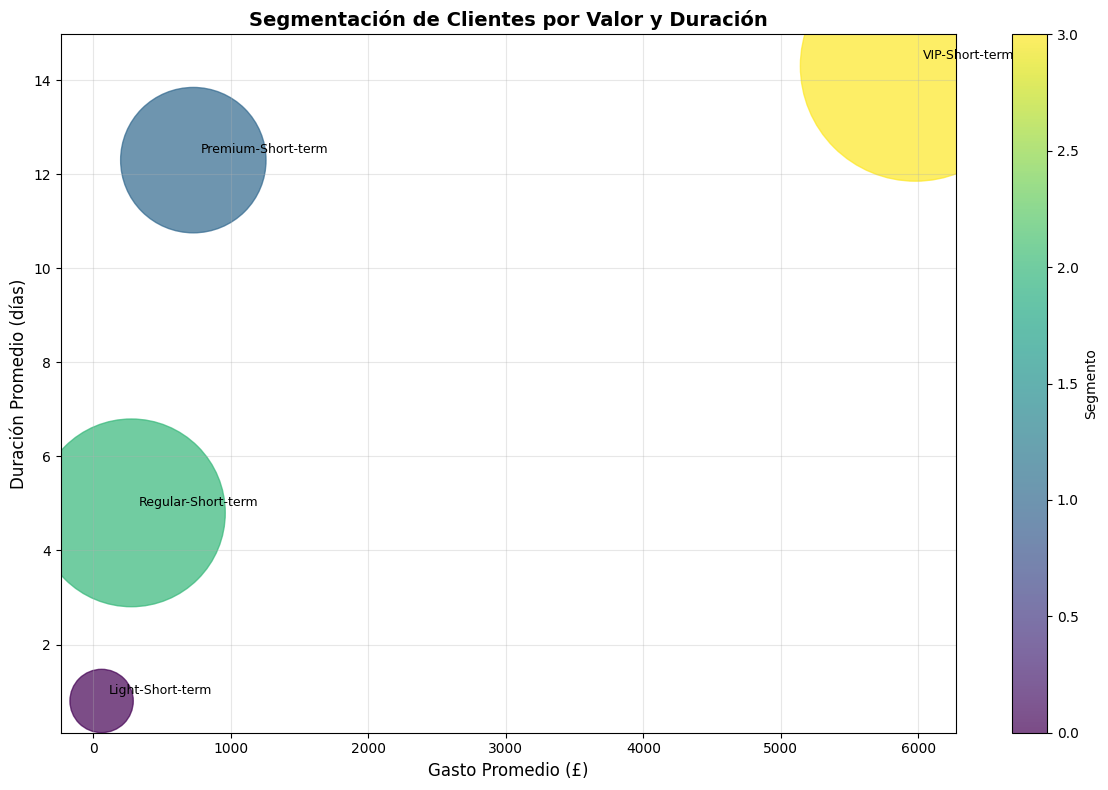

In [21]:
# SEGMENTACIÓN DE CLIENTES 
print("ANÁLISIS DE SEGMENTACIÓN DE CLIENTES")
print("=" * 50)

# Cargar y ejecutar query 
with open('../sql_queries/04_customer_behavior.sql', 'r') as file:
    behavior_query = file.read()

customer_segments_df = con.execute(behavior_query).fetchdf()
print(f"Segmentos de clientes analizados: {len(customer_segments_df)} combinaciones")
display(customer_segments_df)

# Visualización de segmentos
print("\n VISUALIZACIÓN DE SEGMENTOS DE CLIENTES")

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    customer_segments_df['gasto_promedio'], 
    customer_segments_df['duracion_promedio_dias'],
    s=customer_segments_df['total_clientes']*10,  # Tamaño por cantidad de clientes
    c=pd.Categorical(customer_segments_df['segmento']).codes,
    alpha=0.7,
    cmap='viridis'
)

plt.colorbar(scatter, label='Segmento')
plt.xlabel('Gasto Promedio (£)', fontsize=12)
plt.ylabel('Duración Promedio (días)', fontsize=12)
plt.title('Segmentación de Clientes por Valor y Duración', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Anotar los segmentos
for i, row in customer_segments_df.iterrows():
    if row['total_clientes'] > 50:  # Solo anotar segmentos significativos
        plt.annotate(f"{row['segmento']}-{row['duracion_tipo']}", 
                    (row['gasto_promedio'], row['duracion_promedio_dias']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig('../assets/customer_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

## Mapa de Burbujas de Segmentación 

El diagrama de burbujas es una representación de la **Matriz de Valor vs. Duración**. El tamaño de la burbuja indica la cantidad de clientes, la posición horizontal indica el **Gasto Promedio** (Valor), y la posición vertical indica la **Duración Promedio** (Lealtad).

### Interpretación del Mapa:

* **Poder de Compra (Eje X):** El segmento **VIP** tiene un gasto promedio de casi **£6,000**, superando drásticamente a todos los demás.
* **Riesgo de Abandono (Eje Y):** La concentración de todos los segmentos en el área **'Short-term'** (menos de 30 días, aunque el máximo es ~14 días) es una alerta. Indica que la mayoría de los clientes no tienen un período de vida largo en el dataset.
* **Estrategia:** El foco del negocio debe ser **convertir los "VIP Short-term" en "VIP Long-term"** a través de campañas de retención intensivas, ya que tienen el mayor potencial de ingresos.

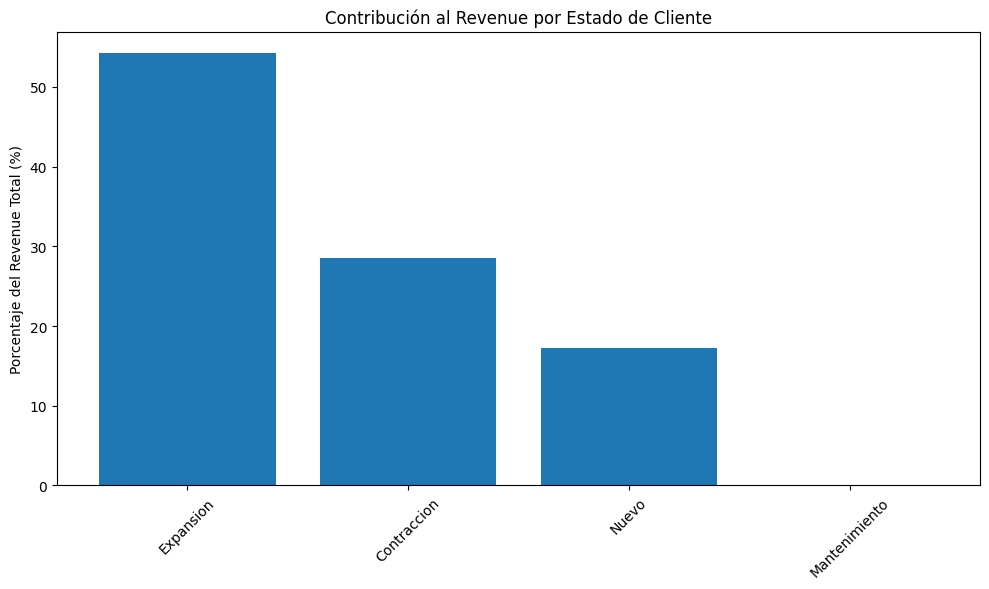

In [22]:
# Gráfico de contribución por estado de cliente
plt.figure(figsize=(10, 6))
estados = resumen_estado['estado_cliente']
contribucion = resumen_estado['revenue_total'] / resumen_estado['revenue_total'].sum() * 100

plt.bar(estados, contribucion)
plt.title('Contribución al Revenue por Estado de Cliente')
plt.ylabel('Porcentaje del Revenue Total (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# Análisis de Churn por Cohorte
print("ANÁLISIS DE CHURN POR COHORTE")
print("=" * 50)

# Cargar y ejecutar query
with open('../sql_queries/05_cohort_churn.sql', 'r') as file:
    churn_query = file.read()

churn_df = con.execute(churn_query).fetchdf()
print(f"Matriz de Churn calculada: {len(churn_df):,} filas")

# Crear matriz pivote para visualización del Churn
churn_pivot = churn_df.pivot_table(
    index='cohort_mes',
    columns='mes_numero',
    values='tasa_churn_acumulada',
    aggfunc='first'
)

print("\n MATRIZ DE CHURN ACUMULADO POR COHORTE:")
display(churn_pivot)

ANÁLISIS DE CHURN POR COHORTE
Matriz de Churn calculada: 325 filas

 MATRIZ DE CHURN ACUMULADO POR COHORTE:


mes_numero,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
cohort_mes,,,,,,,,,,,,,,,,,,,,,
2009-12-01,0.0,64.71,66.60,57.49,61.99,64.08,62.30,65.76,66.39,63.77,...,69.74,73.72,69.74,71.73,74.03,74.45,68.48,69.53,59.27,80.31
2010-01-01,0.0,79.37,68.93,69.45,73.63,69.97,74.15,77.02,72.06,68.15,...,84.86,76.50,80.16,81.46,80.42,75.72,80.68,75.46,94.26,NaN
2010-02-01,0.0,76.20,77.54,70.86,75.40,79.95,80.75,71.39,74.60,72.46,...,79.95,83.96,83.69,85.56,77.01,77.01,83.69,94.12,NaN,NaN
2010-03-01,0.0,81.04,76.98,75.85,76.75,79.68,75.40,69.75,72.46,89.16,...,83.07,82.62,84.42,82.39,79.91,78.78,92.10,NaN,NaN,NaN
2010-04-01,0.0,80.61,80.61,83.67,81.63,77.55,72.45,73.81,89.46,89.12,...,84.35,86.05,85.03,81.97,77.55,94.22,NaN,NaN,NaN,NaN
2010-05-01,0.0,84.25,83.07,82.68,82.28,74.41,78.74,87.40,94.09,91.73,...,87.40,86.22,83.46,84.65,95.28,NaN,NaN,NaN,NaN,NaN
2010-06-01,0.0,82.59,81.11,79.63,77.04,71.48,87.41,91.11,91.85,88.15,...,87.78,86.67,79.63,94.81,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,0.0,84.41,81.72,70.43,70.97,86.02,88.71,85.48,85.48,88.71,...,82.80,76.34,91.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,0.0,79.63,70.37,67.90,82.72,88.27,90.12,87.65,86.42,87.04,...,80.25,93.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


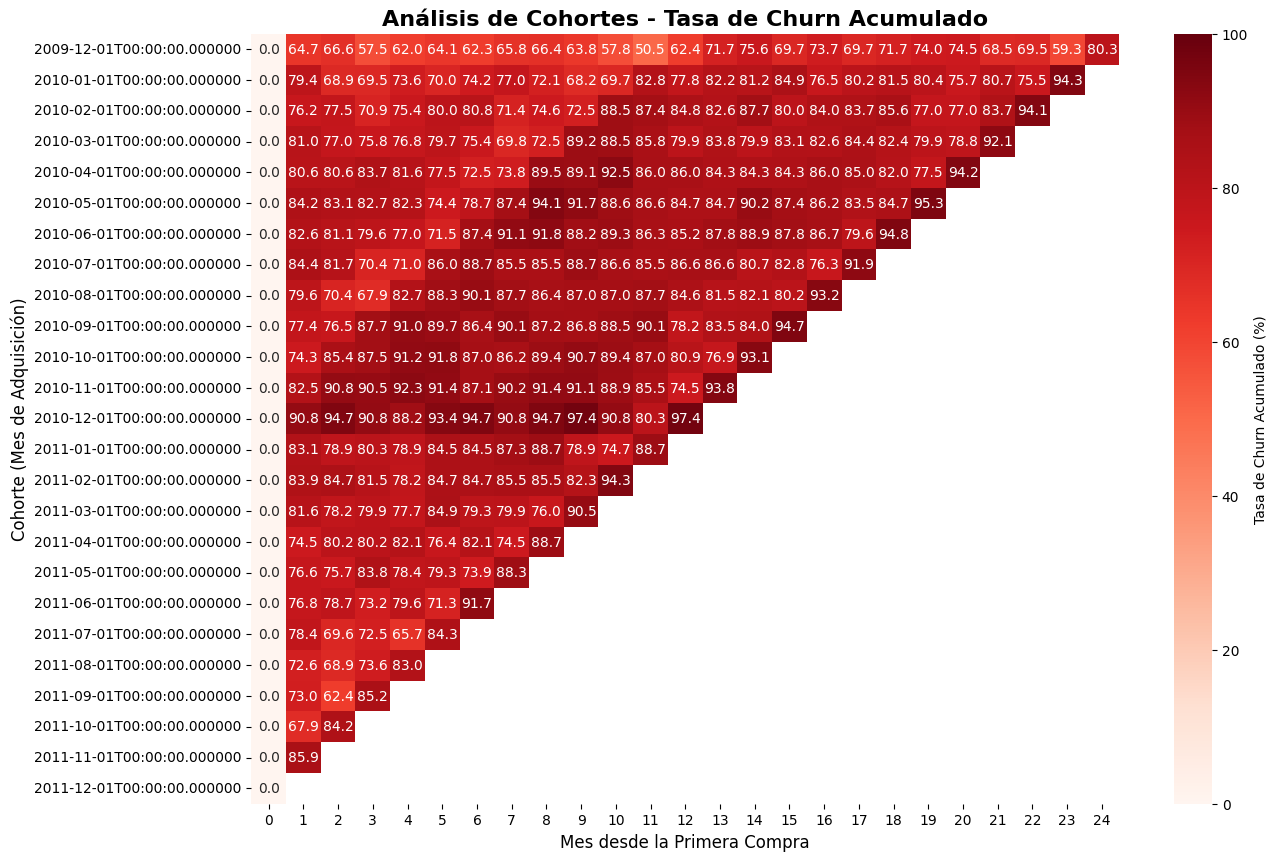

In [29]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    churn_pivot, 
    annot=True, 
    fmt='.1f', 
    mask=churn_pivot.isnull(), # Oculta los NaN
    cmap='Reds',               # Usar rojo para el abandono (Churn)
    vmin=0, vmax=100,          # Rango de 0% a 100% de Churn
    cbar_kws={'label': 'Tasa de Churn Acumulado (%)'}
)
plt.title('Análisis de Cohortes - Tasa de Churn Acumulado', fontsize=16, fontweight='bold')
plt.xlabel('Mes desde la Primera Compra', fontsize=12)
plt.ylabel('Cohorte (Mes de Adquisición)', fontsize=12)
plt.yticks(rotation=0)
plt.show()

In [30]:
# ANÁLISIS DE MÉTRICAS CLAVE Y ESTACIONALIDAD
print("CÁLCULO DE MÉTRICAS CLAVE DE NEGOCIO (ARPU, LTV)")
print("=" * 60)

# Ejecutar query de Métricas Clave (ARPU, LTV) ---
with open('../sql_queries/06_business_metrics.sql', 'r') as file:
    metrics_query = file.read()

metricas_negocio_df = con.execute(metrics_query).fetchdf()

print("MÉTRICAS CLAVE PROMEDIO:")
display(metricas_negocio_df)

#  Ejecutar query de Revenue Mensual (Estacionalidad) ---
print("\n REVENUE POR MES (ANÁLISIS DE ESTACIONALIDAD)")
print("=" * 60)


revenue_estacionalidad_query = """
    WITH customer_monthly_revenue AS (
        SELECT 
            "Customer ID" as customer_id,
            DATE_TRUNC('month', CAST(InvoiceDate AS DATE)) as mes,
            SUM(Quantity * Price) as ingreso_mensual
        FROM ventas
        GROUP BY 1, 2
    )
    SELECT 
        EXTRACT(YEAR FROM mes) as anio,
        EXTRACT(MONTH FROM mes) as mes_num,
        SUM(ingreso_mensual) as revenue_total
    FROM customer_monthly_revenue
    GROUP BY anio, mes_num
    ORDER BY anio, mes_num
"""

revenue_mensual_df = con.execute(revenue_estacionalidad_query).fetchdf()

print("REVENUE TOTAL POR MES/AÑO:")
display(revenue_mensual_df.head(15)) 

CÁLCULO DE MÉTRICAS CLAVE DE NEGOCIO (ARPU, LTV)
MÉTRICAS CLAVE PROMEDIO:


,avg_clientes_activos,avg_revenue_mensual,avg_arpu,ltv_estimado_simple
0,1023.8,709737.16712,693.258702,693.2381



 REVENUE POR MES (ANÁLISIS DE ESTACIONALIDAD)
REVENUE TOTAL POR MES/AÑO:


,anio,mes_num,revenue_total
0,2009,12,686654.160
1,2010,1,557319.062
2,2010,2,506371.066
3,2010,3,699608.991
4,2010,4,594609.192
5,2010,5,599985.790
6,2010,6,639066.580
7,2010,7,591636.740
8,2010,8,604242.650
9,2010,9,831615.001


##  Métricas Clave y Estacionalidad 

Este último análisis consolida las métricas de rendimiento promedio (ARPU, Revenue total) y extrae los datos de Revenue por mes y año para identificar patrones de estacionalidad.

###  Métricas Promedio Clave

* **`avg_arpu` (Average Revenue Per User):** El ingreso promedio generado por un cliente activo en un mes dado. Mide la calidad de los ingresos.
* **`ltv_estimado_simple`:** Una estimación simplificada del LTV. Se calcula dividiendo el Revenue Total por el total de Clientes Activos.

### Estacionalidad del Revenue

El DataFrame de Revenue por mes (`revenue_mensual_df`) se utiliza para graficar las ventas a lo largo del tiempo, revelando los meses pico (ej. Diciembre) y los valles (ej. Enero o Febrero). Esto es esencial para la planificación de inventario y marketing

In [35]:
# resultados para dashboards
metricas_avanzadas = {
    'growth_accounting': resumen_estado,
    'cohort_analysis': cohort_pivot,
    'clv_analysis': clv_analysis,
    'metricas_negocio': metricas_negocio_df 
    }

# Exportar a Excel con múltiples hojas
with pd.ExcelWriter('../results/metricas_avanzadas.xlsx') as writer:
    for nombre, df in metricas_avanzadas.items():
        df.to_excel(writer, sheet_name=nombre, index=False)